In [35]:
##3層の光学エンコーダの圧縮比を減少させる。_

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [37]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[7-1]_rep3_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1127
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/MNIST_AE[7-1]_rep3_result


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [39]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [41]:
#Encoder5
class Encoder(nn.Module):
    def __init__(self,in_features,out_features,alpha=0.6):
        super(Encoder, self).__init__()
        real_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        imag_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = alpha
    
    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) #e^(iαx)
        x = x.T
        x = torch.matmul(self.B, x)
        x = torch.abs(x) ** 2
        x = x.T
        return x

In [42]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out,De_lay,act_fun):
        super(Decoder, self).__init__()
        decoder_layers = []
        in_features = num_in

        act_fun_dict = {
        1: nn.ReLU(),
        2: nn.LeakyReLU(),
        3: nn.Tanh(),
        4: nn.ELU()
        }
        sel_act_fun = act_fun_dict.get(act_fun, nn.ReLU)

        for _ in range(De_lay-1):
            mid_features = in_features+int((num_out-num_in)/De_lay)
            decoder_layers.append(nn.Linear(in_features,mid_features))
            decoder_layers.append(sel_act_fun)
            in_features = mid_features

        decoder_layers.append(nn.Linear(in_features,num_out))
        decoder_layers.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, x):

        x = self.decoder(x)

        return x

In [43]:
class AutoEncoder(nn.Module):
    def __init__(self,num_IN,num_N,En_lay,De_lay,act_fun):
        super(AutoEncoder, self).__init__()

        encoder_layers = []
        in_features = num_IN

        if En_lay > 1:
            for _ in range(En_lay-1):
                mid_features = in_features-int((num_IN-num_N)/En_lay)
                encoder_layers.append(Encoder(in_features,mid_features))
                in_features = mid_features
        
        encoder_layers.append(Encoder(in_features,num_N))
        self.encoder = nn.Sequential(*encoder_layers)

        self.decoder = Decoder(num_N, num_IN,De_lay,act_fun)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.encoder(x) 
        
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [44]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

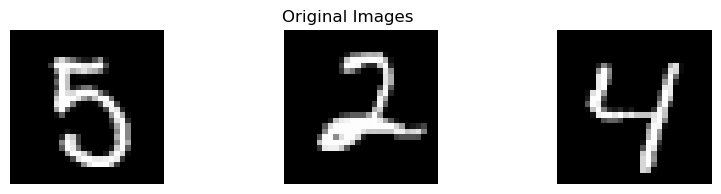

In [45]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:##
        break
show_images(test_images, test_labels,"Original Images")
file_name = 'originalMNISTimage(524).png'
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

In [46]:
def ssim_loss(img1, img2):

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1)*(2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

CompressionAmount:784→784 Epoch: 9/10

loss_train: 0.0048,loss_test: 0.0049,SSIM:0.8914


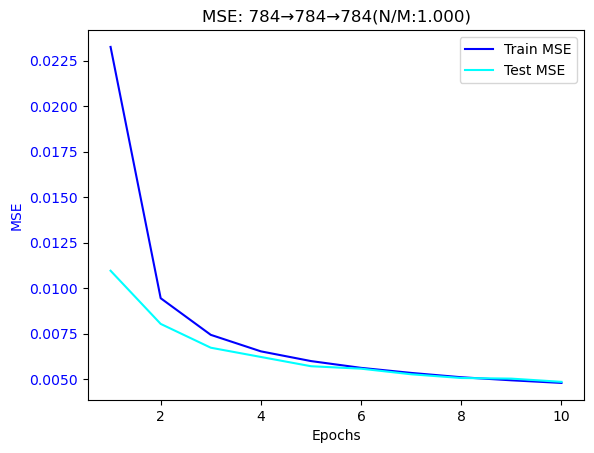

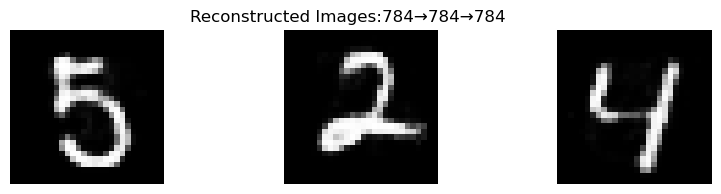

CompressionAmount:784→760 Epoch: 9/10

loss_train: 0.0050,loss_test: 0.0050,SSIM:0.8839


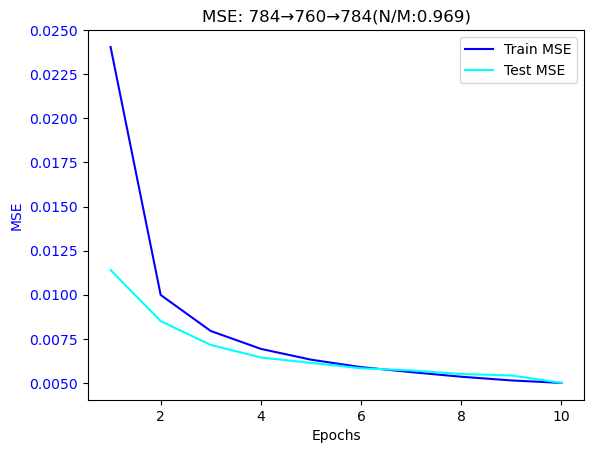

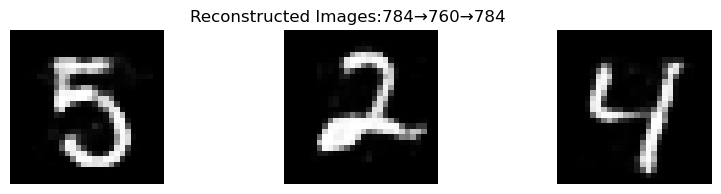

CompressionAmount:784→608 Epoch: 9/10

loss_train: 0.0054,loss_test: 0.0055,SSIM:0.8896


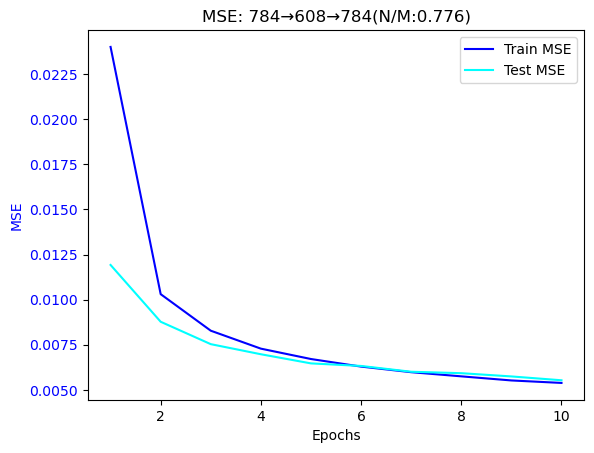

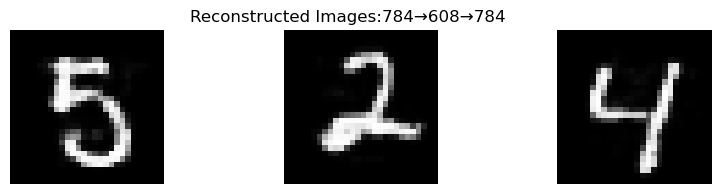

CompressionAmount:784→456 Epoch: 9/10

loss_train: 0.0062,loss_test: 0.0064,SSIM:0.8772


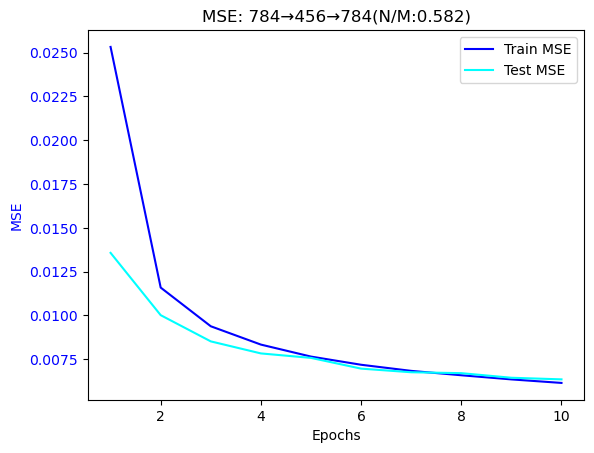

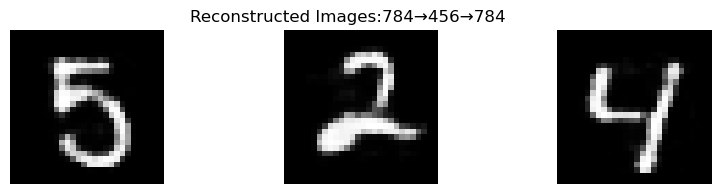

CompressionAmount:784→304 Epoch: 9/10

loss_train: 0.0073,loss_test: 0.0076,SSIM:0.8698


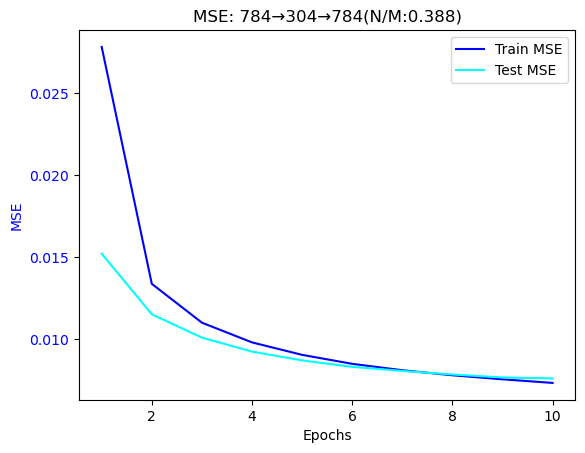

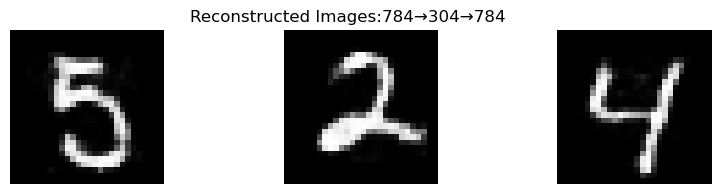

CompressionAmount:784→152 Epoch: 9/10

loss_train: 0.0104,loss_test: 0.0106,SSIM:0.8442


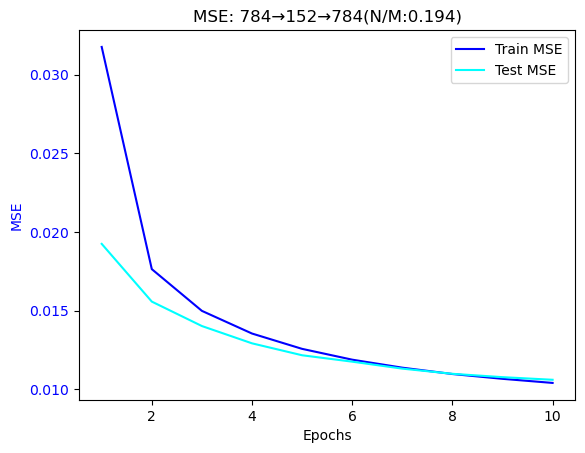

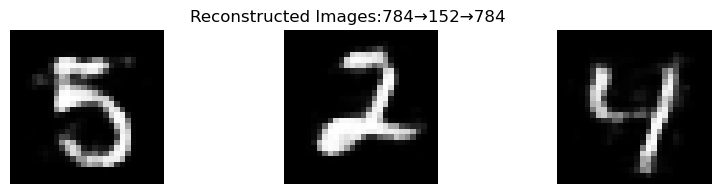

CompressionAmount:784→8 Epoch: 9/1000

loss_train: 0.0505,loss_test: 0.0506,SSIM:0.5168


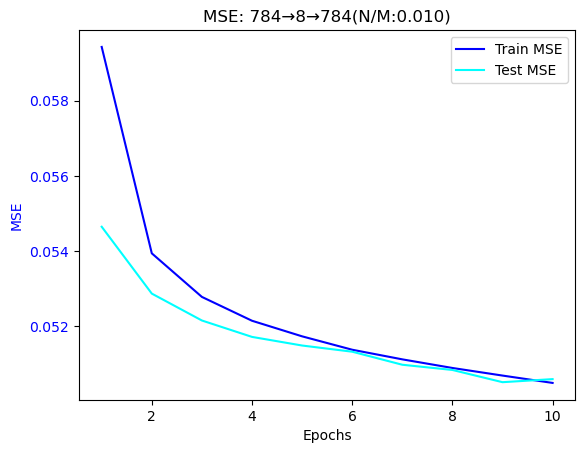

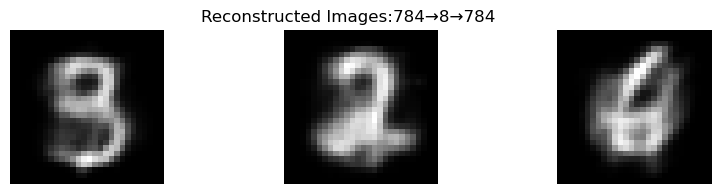

In [47]:
All_loss_train = []
All_loss_test = []
All_ssim =[]

DofIN = 784
DofOUT = 784

max_epochs = 10##
Rep = 98
width = 8 #Rep*width =DofIN 
num_measure = 5
En_lay = 3
De_lay = 3
act_fun = 1

magic = int(Rep/num_measure)*num_measure*width

for i in range(0,Rep):

    num_N = DofIN-i*width

    model = AutoEncoder(DofIN,num_N,En_lay,De_lay,act_fun).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    loss_train_ = []
    loss_test_ = []

    for epoch in range(max_epochs):
        loss_train = 0
        loss_test = 0
        sys.stderr.write('\rCompressionAmount:%d→%d Epoch: %d/%d' % (DofIN, num_N, epoch, max_epochs)) 
        sys.stderr.flush()
        for (x,t) in train_dataloader:

            x, t = x.to(device), t.to(device)
            y = model(x)
            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)

        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x)
                loss = criterion(y, x.view(x.size(0), -1))
        
                loss_test += loss.item()

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_train.append(loss_train_avg)
            All_loss_test.append(loss_test_avg)
            ssim_test = ssim_loss(y.view(-1, 1, 28, 28),x.view(-1, 1, 28, 28)).item()
            All_ssim.append(ssim_test)

    if num_N==DofIN or num_N%(magic/num_measure)==0 or 1 <= num_N <= 10 or num_N in (100,75,50,25): ##    
        
        print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f},SSIM:{ssim_test:.4f}")

        fig, ax1 = plt.subplots()
        ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
        ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('MSE', color = 'blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend()

        title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) #
        plt.title(title)
        file_name = '%d_LOSS%d_%d_%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()

        with torch.no_grad():
            test_images = test_images.to(device)
            reconstructed_images = model(test_images)
            image_title = 'Reconstructed Images:%d→%d→%d'%(DofIN,num_N,DofIN)
            show_images(reconstructed_images.cpu(),test_labels, image_title)
            file_name = '%d_ReImage%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
            full_path = os.path.join(save_directory, file_name)
            plt.savefig(full_path, dpi=100, bbox_inches='tight')
            plt.show()


In [48]:
min_MSE_train = np.min(All_loss_train)
min_MSE_test = np.min(All_loss_test)
min_index_train = All_loss_train.index(min_MSE_train)
min_index_test = All_loss_test.index(min_MSE_test)

print('Train Min:N=%d,MSE=%.4f'%((min_index_train+1)*width,min_MSE_train))
print('Test Min :N=%d,MSE=%.4f'%((min_index_test+1)*width,min_MSE_test))

Train Min:N=40,MSE=0.0048
Test Min :N=24,MSE=0.0048


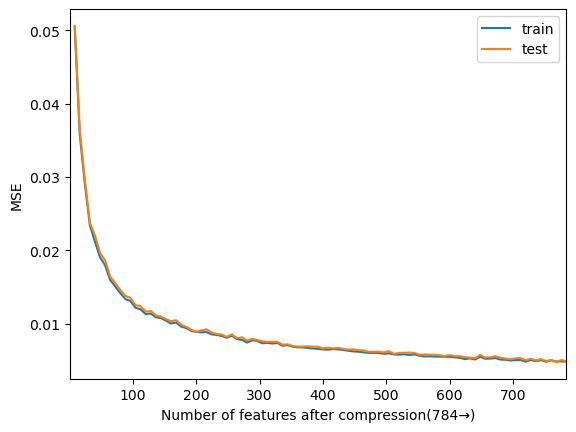

In [49]:

#All_loss_train_cpu = [tensor.cpu().numpy() for tensor in All_loss_train]
#All_loss_test_cpu = [tensor.cpu().numpy() for tensor in All_loss_test]
plt.plot(range(DofIN, DofIN-Rep*width, -width), All_loss_train, label="train")
plt.plot(range(DofIN, DofIN-Rep*width, -width), All_loss_test, label="test")
plt.xlabel('Number of features after compression(%d→)'%(DofIN))
plt.ylabel('MSE')
plt.legend()
plt.xlim(1,DofIN)


file_name = '%d_AE[7-1]_loss.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

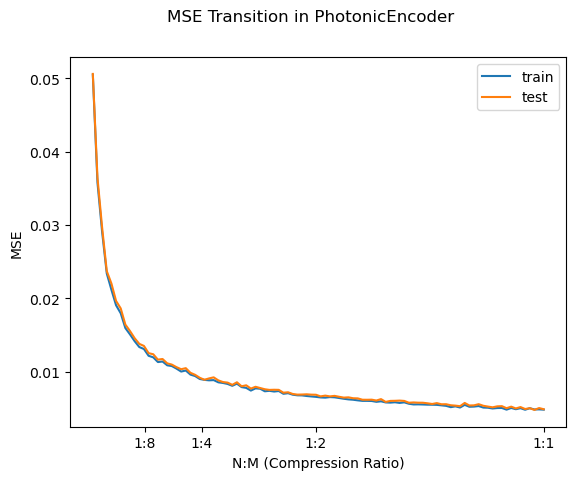

In [50]:
desired_ratios = ["1:1", "1:2", "1:4", "1:8"]
desired_N_values = [DofIN // int(ratio.split(":")[1]) for ratio in desired_ratios] 

rat = np.arange(DofIN, 0, -width)[::-1]

plt.plot(rat, All_loss_train[::-1], label="train")
plt.plot(rat, All_loss_test[::-1], label="test")
plt.xlabel("N:M (Compression Ratio)")
plt.ylabel('MSE')
plt.xticks(ticks=desired_N_values, labels=desired_ratios)
plt.legend()
#plt.xlim(0,1)

title = 'MSE Transition in PhotonicEncoder' ##
plt.suptitle(title)
file_name = '%d_AE[7-1]_loss_ratio.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

In [51]:
'''
plt.plot(rat, All_loss_train[::-1], label="train")
plt.plot(rat, All_loss_test[::-1], label="test")
plt.xlabel("N:M (Compression Ratio)")
plt.ylabel('MSE')
plt.xticks(ticks=desired_N_values, labels=desired_ratios)
plt.legend()
#plt.xlim(0,1)

title = 'MSE Transition in PhotonicEncoder' ##
plt.suptitle(title)
file_name = '%d_AE[7-1]_loss_ratio_ex.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()
'''


'\nplt.plot(rat, All_loss_train[::-1], label="train")\nplt.plot(rat, All_loss_test[::-1], label="test")\nplt.xlabel("N:M (Compression Ratio)")\nplt.ylabel(\'MSE\')\nplt.xticks(ticks=desired_N_values, labels=desired_ratios)\nplt.legend()\n#plt.xlim(0,1)\n\ntitle = \'MSE Transition in PhotonicEncoder\' ##\nplt.suptitle(title)\nfile_name = \'%d_AE[7-1]_loss_ratio_ex.png\'%(int(formatted_date))##\nfull_path = os.path.join(save_directory, file_name)\nplt.savefig(full_path, dpi=100, bbox_inches=\'tight\')\nplt.show()\n'

In [52]:
'''
plt.plot(rat, All_loss_train[::-1], label="train")
plt.plot(rat, All_loss_test[::-1], label="test")
plt.xlabel("N:M (Compression Ratio)")
plt.ylabel('MSE')
plt.xticks(ticks=desired_N_values, labels=desired_ratios)
plt.legend()
#plt.xlim(0,1)
plt.ylim(0.0,0.01)
title = 'MSE Transition in PhotonicEncoder' ##
plt.suptitle(title)
file_name = '%d_AE[7-1]_loss_ratio_expand.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

'''

'\nplt.plot(rat, All_loss_train[::-1], label="train")\nplt.plot(rat, All_loss_test[::-1], label="test")\nplt.xlabel("N:M (Compression Ratio)")\nplt.ylabel(\'MSE\')\nplt.xticks(ticks=desired_N_values, labels=desired_ratios)\nplt.legend()\n#plt.xlim(0,1)\nplt.ylim(0.0,0.01)\ntitle = \'MSE Transition in PhotonicEncoder\' ##\nplt.suptitle(title)\nfile_name = \'%d_AE[7-1]_loss_ratio_expand.png\'%(int(formatted_date))##\nfull_path = os.path.join(save_directory, file_name)\nplt.savefig(full_path, dpi=100, bbox_inches=\'tight\')\nplt.show()\n\n'

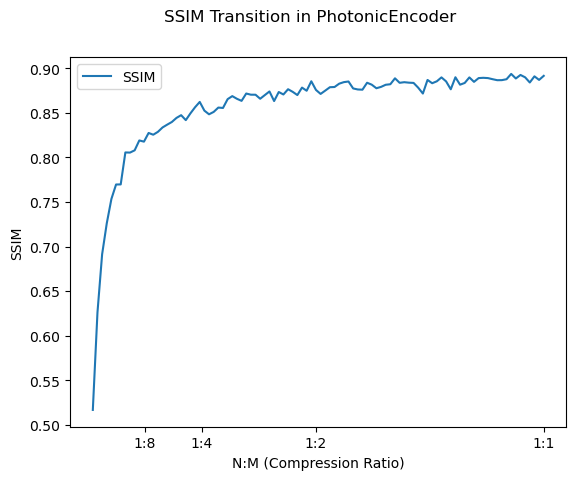

In [53]:
plt.plot(rat, All_ssim[::-1], label="SSIM")
plt.xlabel("N:M (Compression Ratio)")
plt.ylabel('SSIM')
plt.xticks(ticks=desired_N_values, labels=desired_ratios)
plt.legend()
#plt.xlim(0,1)

title = 'SSIM Transition in PhotonicEncoder' ##
plt.suptitle(title)
file_name = '%d_AE[7-1]_ssim.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()


In [54]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[7-1]_rep3List.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(All_ssim)
    writer.writerow(All_loss_test)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/texts
